# Call center data modeling

You are advising a client on the number of call center agents they need to handle their customer support load. We start by modeling the number of phone calls we expect to come into the call center during each hour of the day.

You are provided with a data set of the intervals between phone calls arriving during one day. Each value is a time in minutes indicating the amount of time that passed between receiving two consecutive phone calls.

## Loading the data

In [1]:
#importing libraries
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


Since the values are intervals between calls measured in minutes, this means

* we assume the first call happened at 00:00 (midnight),
* the second call happened at about 00:30 (30 minutes after midnight),
* the third call happened at about 00:33 (30 + 3.4 minutes),
* the fourth call happened at about 00:37, etc.

When we sum the values, we get about 1440 minutes (1 day).

You are told that the number of calls arriving varies quite a lot, depending on which hour of the day it is. The smallest number of calls usually occur around 3am or 4am. Most calls usually come in between 11am and 1pm.

## Data pre-processing
Since we expect different call rates during different hours, we split the data set into 24 separate series — one for each hour of the day.

In [3]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

for hour, calls_in_hour in enumerate(waiting_times_per_hour):
    print(f'{hour:02}:00-{hour + 1:02}:00 - {len(calls_in_hour)} calls')

00:00-01:00 - 5 calls
01:00-02:00 - 4 calls
02:00-03:00 - 6 calls
03:00-04:00 - 8 calls
04:00-05:00 - 26 calls
05:00-06:00 - 53 calls
06:00-07:00 - 93 calls
07:00-08:00 - 173 calls
08:00-09:00 - 254 calls
09:00-10:00 - 345 calls
10:00-11:00 - 496 calls
11:00-12:00 - 924 calls
12:00-13:00 - 858 calls
13:00-14:00 - 382 calls
14:00-15:00 - 185 calls
15:00-16:00 - 207 calls
16:00-17:00 - 263 calls
17:00-18:00 - 419 calls
18:00-19:00 - 531 calls
19:00-20:00 - 400 calls
20:00-21:00 - 137 calls
21:00-22:00 - 51 calls
22:00-23:00 - 20 calls
23:00-24:00 - 16 calls


## Task 1: Plot the number of calls per hour
Use Matplotlib to visualize the number of calls that arrive during each hour of the day, stored in the variable `waiting_times_per_hour`. The call numbers are shown in the output above. You should find an appropriate way to visualize it.

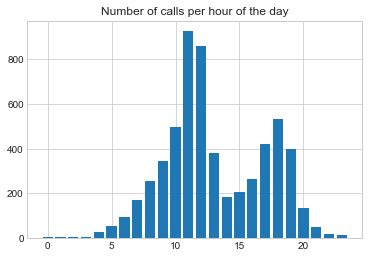

In [4]:
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.title('Number of calls per hour of the day')
plt.show()

## Task 2: Plot a histogram of the durations for one hour
Take the data for the 9th hour (so between 9am and 10am) and plot a histogram showing the distribution over waiting times between calls during that hour.

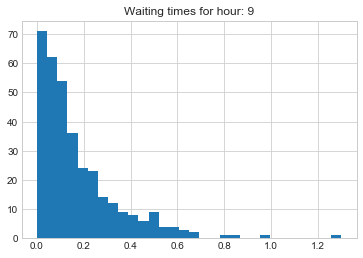

In [5]:
hour = 9
waiting_times_hour = waiting_times_per_hour[hour]
plt.hist(waiting_times_hour, bins=30)
plt.title('Waiting times for hour: %i' % hour)
plt.show()

## Task 3: Guess the distribution
What type of distribution best represents the data in your histogram?

* Identify a type of distribution. **In class you will use this distribution as your likelihood function in a Bayesian inference problem.**
* Guess what the parameters of the distribution are. (This is just a guess for now. In class we will infer the values of the parameters.)
* Plot the pdf of your best guess on top of your histogram, to see if they match.
* **Important:** You have to normalize your histogram so that it will have the same vertical scale as the plot of the pdf. You can normalize a histogram by using the argument `density=True` in the `hist` function.

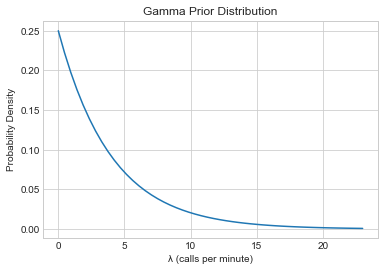

In [6]:
prior_alpha, prior_beta = 1, 0.25 #prior parameters
prior = sts.gamma(a=prior_alpha, scale=1/prior_beta) #prior distribution
x = np.linspace(0, 23)
plt.plot(x, prior.pdf(x)) #plotting prior
plt.ylabel('Probability Density') #label
plt.xlabel('λ (calls per minute)') #label
plt.title('Gamma Prior Distribution') #plot title
plt.show()

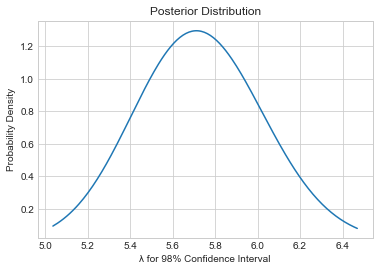

In [7]:
#posterior parameters
post_alpha = prior_alpha + len(waiting_times_hour)
post_beta = prior_beta + sum(waiting_times_hour)

#gamma distribution with posterior parameters
posterior = sts.gamma(a=post_alpha, scale=1/post_beta)

#98% confidence interval
conf98 = (posterior.ppf(0.01), posterior.ppf(0.99))

#plotting posterior
x = np.linspace(conf98[0], conf98[1], 200) #x-axis, for 98% confidence interval
y = posterior.pdf(x) #y-axis, probability density function

plt.plot(x, y)
plt.title('Posterior Distribution')
plt.xlabel('λ for 98% Confidence Interval') #call rate = lambda
plt.ylabel('Probability Density')
plt.show()

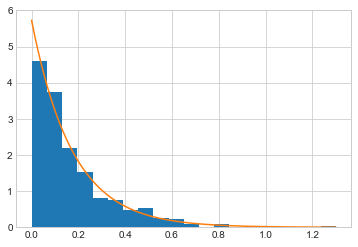

In [8]:
lambda_ = posterior.mean() #expected value of lambda(posterior) to use as parameter
#plotting likelihood function for lamba over histogram obtained in Task 2
plt.hist(waiting_times_hour, bins=20, density=True)
x = np.linspace(0, max(waiting_times_hour), 200)
y = sts.expon.pdf(x, scale=1/lambda_) #exponential probability density function
plt.plot(x, y)
plt.show()

### Assignment Continuation
Compute a 98% posterior confidence interval over the number of calls per minute (the call
rate λ ) for each hour of the day — so you will have 24 confidence intervals. Also, compute
the posterior mean of λ for each hour of the day

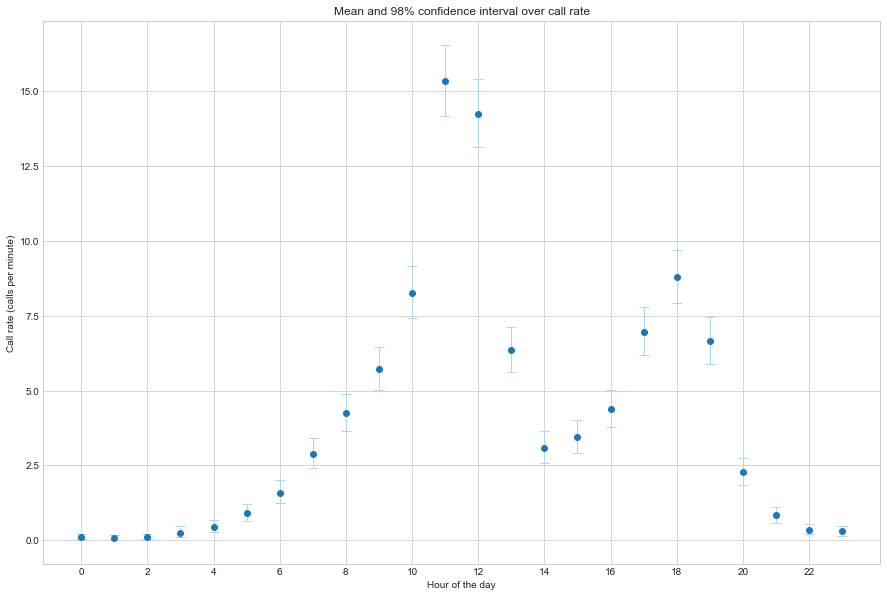

In [9]:
conf = 0.98 #confidence interval
mean_hour = np.empty(24) #to store mean per hour

#to store lower & upper confidence bound, per hour
conf_lower, conf_upper = np.empty(24), np.empty(24)

for hour, waiting_times_hour in enumerate(waiting_times_per_hour):
    post_alpha = prior_alpha + len(waiting_times_hour)
    post_beta = prior_beta + sum(waiting_times_hour)
    posterior = sts.gamma(a=post_alpha, scale=1/post_beta) #gamma distribution for each hour
    mean_hour[hour] = posterior.mean() #lambda EV
    conf_lower[hour] = posterior.ppf((1 - conf) / 2) #confidence interval upper bound
    conf_upper[hour] = posterior.ppf((1 + conf) / 2) #confidence interval lower bound

plt.figure(figsize=(15, 10))
x = range(24) #0 to 23, to represent nth hour
plt.errorbar(x, mean_hour,
             yerr=[mean_hour - conf_lower, conf_upper - mean_hour], fmt='o',
             ecolor='lightblue', elinewidth=1, capsize=5)
plt.xticks(np.arange(0, 23, step=2))
plt.xlabel('Hour of the day')
plt.ylabel('Call rate (calls per minute)')
plt.title('Mean and 98% confidence interval over call rate')
plt.show()

We can see the average(mean) calls per minute for each hour with 98% confidence interval showing that the 98% chances of call rate falling between the range. As the average increases, the range increases showing that during high demand(peak) times the call rate can vary more than the other times. If the call center has no budget constraints then it is recommended that the center allots agents matching the upper limit of confidence interval for each hour and if there are budget constraints, it is recommended to not go below the lower limit of confidence interval. We can take a look at the graph and see for ourselves the high & moderate peak times which require more agents and also troughs which require less agents. For eg., 11-12 hour is the highest peak where the average call rate is 16 calls/minute and the error bars plotted on that point denote the confidence interval. The points with low height of error bars denote higher certainity of call rate being near or equal to average call rate for that hour and vice versa.

# Optional



Generate 1000 samples from a normal distribution with mean 100 and standard
deviation 10. 

How many of the numbers are at least 2 standard deviations away
from the mean? 

How many to you expect to be at least 2 standard deviations away
from the mean?

In [10]:
#standard deviation, mean, number of samples
sd, mean, samples_count = 10, 100, 1000
samples = np.random.normal(mean,sd,samples_count) #1000 samples
sd_2 = np.absolute(samples - mean) > 2 * sd
print(np.sum(sd_2))

44


Toss a fair coin 50 times. 

How many heads do you have? 

How many heads to you expect to have?

In [11]:
chance = 0.5 #as we have a fair coin, tails:head::50:50
toss_count = 50 #number of tosses
heads = np.random.binomial(toss_count, chance) #sampling
print("Total heads obtained in random sampling: ", heads)
print("Theoretically expected heads: total tosses*probability of head = 50*0.5 = 25")

Total heads obtained in random sampling:  28
Theoretically expected heads: total tosses*probability of head = 50*0.5 = 25


Roll a 6-sided die 1000 times.

How many 6s did you get? 

How many 6s do you expect to get?

In [12]:
chance = [0.167,0.167,0.167,0.167,0.167,0.167] #probability for each side of a fair die, 1/6
roll_count = 1000 #number of times die rolled
six = np.random.multinomial(roll_count, chance)[-1] #as 6 is the last element
print("Total sixes obtained in random sampling: ", six)
print("Theoretically expected sixes: total rolls*probability of 6 = 166.67")

Total sixes obtained in random sampling:  182
Theoretically expected sixes: total rolls*probability of 6 = 166.67


How much area (probability) is to the right of 1.5 for a normal distribution with mean
0 and standard deviation 2?

In [13]:
#we can simply deduct the cdf which comprises the left part
1-sts.norm.cdf(1.5,0,2) 

0.22662735237686826